In [2]:
# Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV

## Exercise 1 - Data Preparation

### 1.1 - Load the dataset, inspect feature names and target distribution. Comment on dataset imbalance. 

In [3]:
df = pd.read_csv('data.csv')
# Finn ut hva som menes med Feature names og target distribution, boka maybe

# Feature names
print("Feature names:", list(df.columns))


# Target distribution
print(df['diagnosis'].value_counts())
print("\nFraction:\n", df['diagnosis'].value_counts(normalize=True))

Feature names: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
diagnosis
B    357
M    212
Name: count, dtype: int64

Fraction:
 diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64


The dataset is a bit unbalanced, as it does have more benign than malicious data, but I think the amount of malicious data is enough. If I am unlucky the random splits might turn out with too few malicious but it should be enough.

### 1.2 - Analyze all features with and without standardization (i.e., zero mean and unit variance). Plot the feature analysis with and without standardization and decide which version is more suitable.

No Standardization
                                mean         std
radius_mean               14.127292    3.524049
texture_mean              19.289649    4.301036
perimeter_mean            91.969033   24.298981
area_mean                654.889104  351.914129
smoothness_mean            0.096360    0.014064
compactness_mean           0.104341    0.052813
concavity_mean             0.088799    0.079720
concave points_mean        0.048919    0.038803
symmetry_mean              0.181162    0.027414
fractal_dimension_mean     0.062798    0.007060
radius_se                  0.405172    0.277313
texture_se                 1.216853    0.551648
perimeter_se               2.866059    2.021855
area_se                   40.337079   45.491006
smoothness_se              0.007041    0.003003
compactness_se             0.025478    0.017908
concavity_se               0.031894    0.030186
concave points_se          0.011796    0.006170
symmetry_se                0.020542    0.008266
fractal_dimension_se

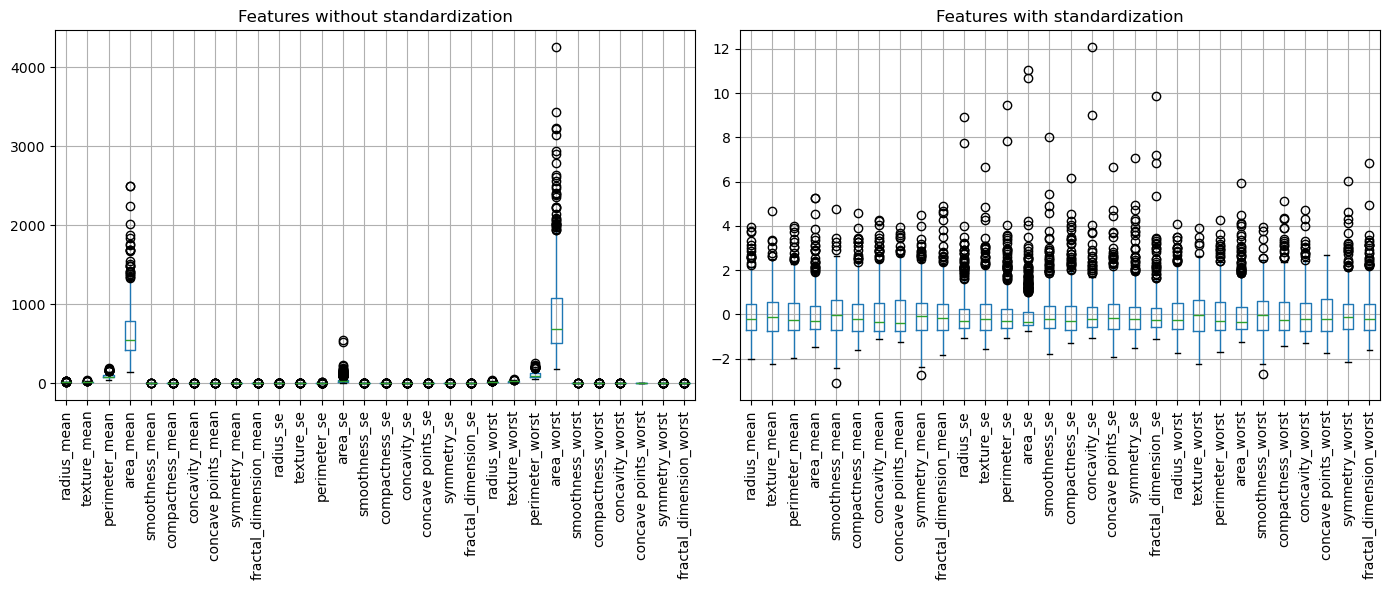

In [4]:
# Drop id and diagnosis to get features, these are not numerical
X = df.drop(columns=["id", "diagnosis"], errors="ignore")

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Describe statistics before and after
print("No Standardization\n", X.describe().T[['mean','std']])
print("\nStandardization:\n", X_scaled.describe().T[['mean','std']])

# Plot boxplots for all features
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
X.boxplot()
plt.title("Features without standardization")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
X_scaled.boxplot()
plt.title("Features with standardization")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Looking at the plots it seems like it is best to used the standardized one, as the left plot shows that there are huge difference in scaling, where some values are in the thousands, and others are barely over zero. Using the standradized one means the scales are more comparable and therefore not having some values dominate the models. And the esthetics of the right boxplot looks right to use.

### 1.3 - Comment on importance of three way split with respect to hyperparameter search and robustness of any learned model.
The three way split is important in regards to hyperparameters as we dont use the test set to cheat the hyperparameters to fit the test set.
For robustness its good because it keeps the test set seperate from the hyperparameter search, and thus we don't risk to fit the hyperparameters to the test data, but rather use the test data to see how the hyperparameters works on new data.

## Exercise 2 - Decision Trees
### Splits

### DO NOT TOUCH
(After closer reconsideration, it turn out the random state makes sure the splits are the same, this was made to make sure it was the same, woops. Keeping this now so i dont have to split anymore i guess.)

In [5]:
# Features and target
X = df.drop(columns=["id", "diagnosis"], errors="ignore")
y = df["diagnosis"].map({"M": 1, "B": 0})

# Split into 60% train, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (341, 30)
Validation: (114, 30)
Test: (114, 30)


### 2.1 - Train a Decision Tree classifier using default parameters. Evaluate it on validation sets from original splits (report accuracy mean and std).

In [6]:
# Only training set
# Modell with default parameters
clf = DecisionTreeClassifier(random_state=42)

# 5-fold cross-validation on training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")

print("Cross Validation Accuracy mean:", np.mean(cv_scores))
print("Cross Validation Accuracy std: ", np.std(cv_scores))

decison_tree_train_result = cv_scores


Cross Validation Accuracy mean: 0.9238704177323104
Cross Validation Accuracy std:  0.040627367474774134


In [7]:
# Validation set
clf.fit(X_train, y_train)
val_score = clf.score(X_val, y_val)
print("Validation Accuracy:", val_score)


Validation Accuracy: 0.9385964912280702


Validation set better accuracy than cross validation mean

### 2.2 - From the trained model, comment on feature importance values and identify the top 3 features from your model.

In [8]:
# Get important features from the trained model, all features, and sorting them by importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Feature importances:\n", feature_importances)

Feature importances:
 perimeter_worst            0.704881
concave points_worst       0.136016
texture_worst              0.038957
smoothness_worst           0.032706
fractal_dimension_se       0.028150
area_se                    0.019922
symmetry_mean              0.010456
radius_mean                0.009410
radius_worst               0.009410
area_worst                 0.008365
smoothness_se              0.001726
area_mean                  0.000000
perimeter_mean             0.000000
texture_mean               0.000000
perimeter_se               0.000000
texture_se                 0.000000
radius_se                  0.000000
fractal_dimension_mean     0.000000
concavity_mean             0.000000
concave points_mean        0.000000
smoothness_mean            0.000000
compactness_mean           0.000000
symmetry_se                0.000000
compactness_se             0.000000
concavity_se               0.000000
concave points_se          0.000000
compactness_worst          0.000000
concav

The model places high importance perimieter_worst, a little important on concave points_worst. It also places absolutely no importance at all on about 20 features. To me, this feels a little weird but perimeter_worst might just be a good classifier between malicious and benign. It might also be a case of overfitting when it relies that mch on one value.

### 2.3 - Vary the max depth parameter (e.g., depth 2-10). Use validation accuracy (mean ± std from cross-validation on the training set) to choose the best depth. Provide performance for each chosen depth (at-least 5 to be reported) and discuss the aspects of overfitting vs. underfitting. 

In [9]:
# Varying max depth from 2 to 10 
depths = range(2, 11)

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
    print(f"Max Depth: {d}, CV Accuracy mean: {np.mean(cv_scores):.4f}, std: {np.std(cv_scores):.4f}")

Max Depth: 2, CV Accuracy mean: 0.9298, std: 0.0309
Max Depth: 3, CV Accuracy mean: 0.9355, std: 0.0236
Max Depth: 4, CV Accuracy mean: 0.9326, std: 0.0343
Max Depth: 5, CV Accuracy mean: 0.9298, std: 0.0309
Max Depth: 6, CV Accuracy mean: 0.9298, std: 0.0395
Max Depth: 7, CV Accuracy mean: 0.9239, std: 0.0280
Max Depth: 8, CV Accuracy mean: 0.9239, std: 0.0406
Max Depth: 9, CV Accuracy mean: 0.9239, std: 0.0406
Max Depth: 10, CV Accuracy mean: 0.9239, std: 0.0406


The accuracy is about the same, allthough Depth=3 does have the highest mean aswell as the lowest std. The variance does increase whilst mean starts to decrease from max depth 6 and onwards, except for std on 7, this might be a sign of overfitting. The accuracy and std is worse on max depth 2 than 3, this could be some underfitting. The first CV training was also worse than depth 2

In [10]:
# Max depth 3 on validation set
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)
val_score_dt = clf.score(X_val, y_val)
print("Validation Accuracy with max depth 3:", val_score_dt)

best_decision_tree_results = {
    "max_depth": 3,
    "val_acc": val_score_dt
}


Validation Accuracy with max depth 3: 0.9385964912280702


Max depth 3 does get higher accuraccy

### 2.4 - Repeat previous exercise with different min samples leaf values. Which setting generalizes best according to the validation set?

In [11]:
# For loops for min_samples_leaf from 1 to 20, both mean, std, and validation accuracy, 5 decimal places
leaf_sizes = range(1, 21)
for leaf_size in leaf_sizes:
    clf = DecisionTreeClassifier(min_samples_leaf=leaf_size, random_state=42)
    clf.fit(X_train, y_train)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
    print(f"Cross Validation Accuracy mean with min_samples_leaf   {leaf_size}:", np.round(np.mean(cv_scores), 5), "mean")
    print(f"Cross Validation Accuracy std with min_samples_leaf    {leaf_size}:", np.round(np.std(cv_scores), 5), "std")
    val_score = clf.score(X_val, y_val)
    print(f"Validation Accuracy with min_samples_leaf              {leaf_size}:", np.round(val_score, 5), "val\n")


Cross Validation Accuracy mean with min_samples_leaf   1: 0.92387 mean
Cross Validation Accuracy std with min_samples_leaf    1: 0.04063 std
Validation Accuracy with min_samples_leaf              1: 0.9386 val

Cross Validation Accuracy mean with min_samples_leaf   2: 0.93261 mean
Cross Validation Accuracy std with min_samples_leaf    2: 0.03151 std
Validation Accuracy with min_samples_leaf              2: 0.9386 val

Cross Validation Accuracy mean with min_samples_leaf   3: 0.93261 mean
Cross Validation Accuracy std with min_samples_leaf    3: 0.02709 std
Validation Accuracy with min_samples_leaf              3: 0.92105 val

Cross Validation Accuracy mean with min_samples_leaf   4: 0.92664 mean
Cross Validation Accuracy std with min_samples_leaf    4: 0.02471 std
Validation Accuracy with min_samples_leaf              4: 0.92105 val

Cross Validation Accuracy mean with min_samples_leaf   5: 0.92084 mean
Cross Validation Accuracy std with min_samples_leaf    5: 0.02381 std
Validation Ac

For min_samples_leaf 1, 2, 19, 20 gave the same accuracy on the validation set. Low number of leaf samples might have high variance and therefore overfit, whilst the the (longer,deeper?) tree might have to high bias and underfit. Also interesting is the mean from the training splits keep getting worse the more min samples gets added.

These min samples gives the same result as the best max depth setting.

As a summary, decision tree gives the same validation accuracy regardless of settings, be it max depth or min sample leaves or default settings.

## Exercise 3: Support Vector MAchines (SVM)

### 3.1 - Train a linear SVM (kernel="linear") and evaluate on validation sets (use the original 5 splits that was created in previous exercise). Report accuracy mean, std and plot the ROC for each split.

SVM Cross Validation Accuracy mean: 0.96483 mean
SVM Cross Validation Accuracy std: 0.01492 std


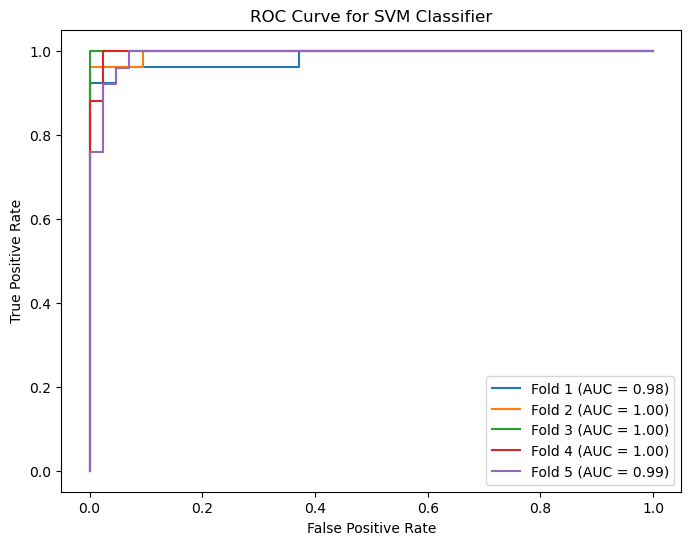

SVM kernel=linear Validation Accuracy: 0.96491 val


In [12]:
# Trains a linear SVM (kernel="linear") and evaluate on validation sets (use the original 5 splits that was created in previous exercise). Report accuracy mean, std and plot the ROC for each split.
svm_clf = make_pipeline(StandardScaler(), SVC(kernel="linear", random_state=42, probability=True))
cv_scores_svm_linear = cross_val_score(svm_clf, X_train, y_train, cv=5, scoring="accuracy")



print("SVM Cross Validation Accuracy mean:", np.round(np.mean(cv_scores_svm_linear), 5), "mean")
print("SVM Cross Validation Accuracy std:", np.round(np.std(cv_scores_svm_linear), 5), "std")


skf = StratifiedKFold(n_splits=5, shuffle=False)
plt.figure(figsize=(8,6))
for i, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    svm_clf.fit(X_tr, y_tr)
    y_proba = svm_clf.predict_proba(X_va)[:, 1]
    fpr, tpr, _ = roc_curve(y_va, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Fold {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier')
plt.legend()
plt.show()

svm_clf.fit(X_train, y_train)
val_score_svm_linear = svm_clf.score(X_val, y_val)
print("SVM kernel=linear Validation Accuracy:", np.round(val_score_svm_linear, 5), "val")

# Best results for linear is this one, so values saved for comparison

ROC shows how good the model seperates by class.
False positive rate - how many begign being classified as malignant here, false as true
True positive rate - Malignant being classified as malignant, true as true

### 3.2 - Train an Radial Basis Function (RBF) kernel SVM. Compare its performance to the linear kernel using validation accuracy. Plot ROC for these models.

RBF SVM Cross Validation Accuracy mean: 0.96475 mean
RBF SVM Cross Validation Accuracy std: 0.01506 std


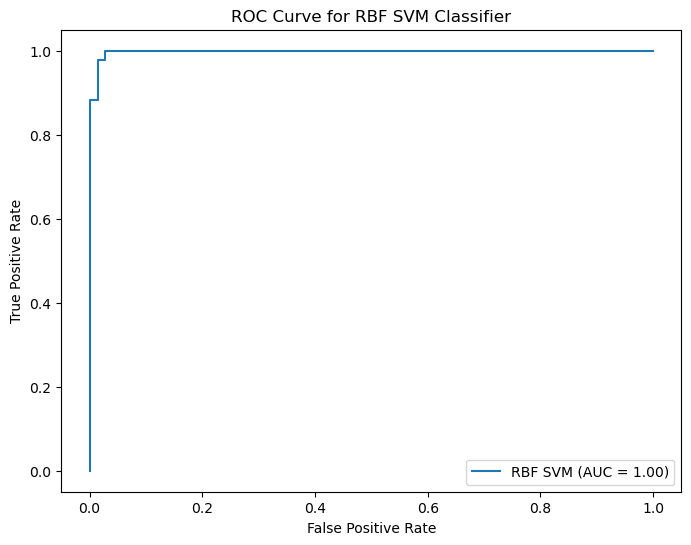

In [13]:
# Train same splits on RBF model
svm_rbf_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma="scale", random_state=42, C=1, probability=True))

rbf_cv = cross_val_score(svm_rbf_clf, X_train, y_train, cv=5, scoring="accuracy")
print("RBF SVM Cross Validation Accuracy mean:", np.round(np.mean(rbf_cv), 5), "mean")
print("RBF SVM Cross Validation Accuracy std:", np.round(np.std(rbf_cv), 5), "std")

# ROC on validation set
y_proba_rbf = svm_rbf_clf.fit(X_train, y_train).predict_proba(X_val)[:, 1]
fpr_rbf, tpr_rbf, _ = roc_curve(y_val, y_proba_rbf)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

plt.figure(figsize=(8,6))
plt.plot(fpr_rbf, tpr_rbf, label=f'RBF SVM (AUC = {roc_auc_rbf:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RBF SVM Classifier')
plt.legend()
plt.show()

# Saving best fold results for comparison
best_rbf_fold_idx = int(np.argmax(rbf_cv))
best_rbf_fold_score = rbf_cv[best_rbf_fold_idx]

rbf_results_trainingset = {
    "cv_scores": rbf_cv,
    "cv_mean": rbf_cv.mean(),
    "cv_std": rbf_cv.std(),
    "best_fold": best_rbf_fold_idx + 1,
    "best_fold_acc": best_rbf_fold_score,
    "roc_auc": roc_auc_rbf
}

# Pointy curves cause few data??

Comparing the validation accuracy between these two models we get:
 * SVM kernel=linear Validation Accuracy: 0.96491
 * RBF SVM Cross Validation Accuracy mean: 0.96475

Currently the SVM with linear kernel is 0.0002 ahead, or 0.02%, which is basically no difference in this dataset, considering the size of the set

### 3.3 - Experiment with different values of C (regularization strength). Use the validation set to select the best C. Report results as a plot of accuracy vs. C

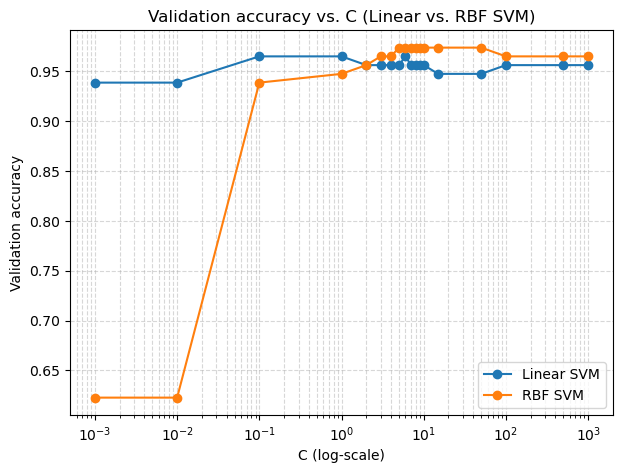

Best Linear SVM:  C=0.1  | Val acc=0.9649
Best RBF SVM:     C=5  | Val acc=0.9737


In [14]:
Cs = [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 50, 100, 500, 1000]

# Pipelines for linear and RBF
def make_lin(C): return make_pipeline(StandardScaler(), SVC(kernel="linear", C=C, probability=True, random_state=42))
def make_rbf(C): return make_pipeline(StandardScaler(), SVC(kernel="rbf",    C=C, gamma="scale", probability=True, random_state=42))

lin_val_acc = []
rbf_val_acc = []

# Train on training set, evaluate on validation set for each C
for C in Cs:
    lin = make_lin(C)
    rbf = make_rbf(C)

    lin.fit(X_train, y_train)
    rbf.fit(X_train, y_train)

    lin_val_acc.append(lin.score(X_val, y_val))
    rbf_val_acc.append(rbf.score(X_val, y_val))

# Plot accuracy vs C for both models
plt.figure(figsize=(7,5))
plt.plot(Cs, lin_val_acc, marker='o', label='Linear SVM')
plt.plot(Cs, rbf_val_acc, marker='o', label='RBF SVM')
plt.xscale('log')
plt.xlabel('C (log-scale)')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy vs. C (Linear vs. RBF SVM)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# Best C and accuracy for both models
best_lin_idx = int(np.argmax(lin_val_acc))
best_rbf_idx = int(np.argmax(rbf_val_acc))

print(f"Best Linear SVM:  C={Cs[best_lin_idx]}  | Val acc={lin_val_acc[best_lin_idx]:.4f}")
print(f"Best RBF SVM:     C={Cs[best_rbf_idx]}  | Val acc={rbf_val_acc[best_rbf_idx]:.4f}")

# Save for comparions
best_rbf_idx = int(np.argmax(rbf_val_acc))

best_rbf_results = {
    "C": Cs[best_rbf_idx],
    "val_acc": rbf_val_acc[best_rbf_idx]
}

C strength is how much the SVM tries to seperate classes. Low C means it allows more mistakes during training and can give better generalization, also might underfit.
High C is more strict when classifying during training, also risks overfitting.

### 3.4 - Experiment with different γ values for the RBF kernel. Discuss the effect on bias-variance trade-off for all experimented values. Select the best γ using the validation set and report the performance on validation set.

Gammas: [0.001, 0.003, 0.006, 0.009, 0.01, 0.02, 0.03, 0.1, 0.3, 1, 3, 10]
Validation accuracies: [0.9386, 0.9561, 0.9561, 0.9649, 0.9649, 0.9649, 0.9649, 0.9649, 0.9298, 0.6228, 0.6228, 0.6228]
Best gamma: 0.009 | Validation accuracy: 0.9649


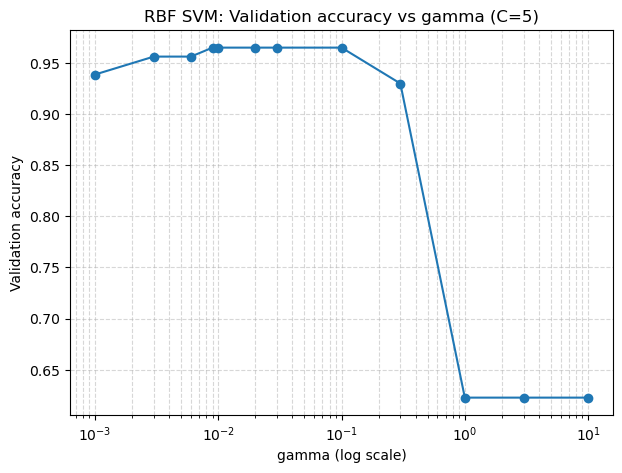

In [15]:

C_fixed = 5  # C from previous experiment

# Gamma values to test
gammas = [0.001, 0.003, 0.006, 0.009, 0.01, 0.02, 0.03, 0.1, 0.3, 1, 3, 10]

val_accs = []
for g in gammas:
    rbf = make_pipeline(StandardScaler(),
                        SVC(kernel="rbf", C=C_fixed, gamma=g, probability=True, random_state=42))
    rbf.fit(X_train, y_train)
    val_accs.append(rbf.score(X_val, y_val))

# Select best gamma
best_idx = int(np.argmax(val_accs))
best_gamma = gammas[best_idx]
best_val_acc = val_accs[best_idx]

print("Gammas:", gammas)
print("Validation accuracies:", [round(a, 4) for a in val_accs])
print(f"Best gamma: {best_gamma} | Validation accuracy: {best_val_acc:.4f}")

plt.figure(figsize=(7,5))
plt.plot(gammas, val_accs, marker='o')
plt.xscale('log')
plt.xlabel('gamma (log scale)')
plt.ylabel('Validation accuracy')
plt.title(f'RBF SVM: Validation accuracy vs gamma (C={C_fixed})')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

## Exercise - 4: Model Comparison

### 4.1 - Compare Decision Tree and SVM results from the training set (cross-validation mean ± std) and validation set. Plot the performance comparison plots (e.g., scatter plots, ROC curves). Which model generalizes better?

In [16]:
# Training result decision tree
decison_tree_train_result
# Best decision tree results for comparison
best_decision_tree_results

# Linear SVM results for comparison
np.mean(cv_scores_svm_linear)
np.std(cv_scores_svm_linear)
val_score_svm_linear

# Best RBF training set results for comparison
rbf_results_trainingset
# RBF SVM results for comparison
best_rbf_results

{'C': 5, 'val_acc': 0.9736842105263158}

In [17]:
# Samle alle modellresultatene i én tabell
results = pd.DataFrame({
    "Model": ["Decision Tree", "SVM (Linear)", "SVM (RBF)"],
    "CV Mean": [
        np.mean(decison_tree_train_result),
        np.mean(cv_scores_svm_linear),
        rbf_results_trainingset["cv_mean"]
    ],
    "CV Std": [
        np.std(decison_tree_train_result),
        np.std(cv_scores_svm_linear),
        rbf_results_trainingset["cv_std"]
    ],
    "Validation Accuracy": [
        best_decision_tree_results["val_acc"],
        val_score_svm_linear,
        best_rbf_results["val_acc"]
    ]
})

print(results)


           Model   CV Mean    CV Std  Validation Accuracy
0  Decision Tree  0.923870  0.040627             0.938596
1   SVM (Linear)  0.964834  0.014924             0.964912
2      SVM (RBF)  0.964749  0.015056             0.973684


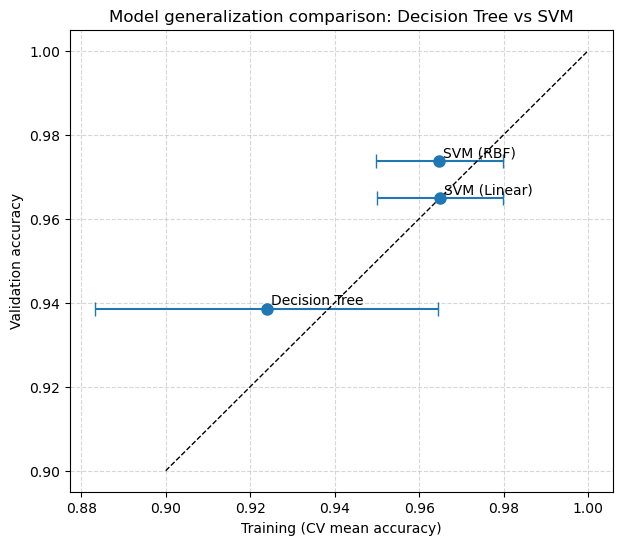

In [18]:
plt.figure(figsize=(7,6))
plt.errorbar(results["CV Mean"], results["Validation Accuracy"], 
             xerr=results["CV Std"], fmt='o', capsize=5, markersize=8)

for i, row in results.iterrows():
    plt.text(row["CV Mean"]+0.001, row["Validation Accuracy"]+0.001, 
             row["Model"], fontsize=10)

# Perfect generalization line
plt.plot([0.9, 1.0], [0.9, 1.0], 'k--', lw=1)
plt.xlabel("Training (CV mean accuracy)")
plt.ylabel("Validation accuracy")
plt.title("Model generalization comparison: Decision Tree vs SVM")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


The decision tree has a bit lower accuracy for both validation and training than the SVM variants. The decision tree also has higher variance and these characteristics tell me that the decision tree is worse for this task than the SVM variants.
To my understanding the SVM RBF variant has a slight tendency to overfits as the point is above the diagoanl. The SVM linear variant is bang on the line but the validation accuracy is a bit lower. Both their variance is about the same. Even though the RBF kernel is not directly on the diagonal, it is close enough to say it is robust enough and generalizes best because of the increased accuracy.

### 4.2 - Discuss the trade-off between usability and accuracy for this dataset. Which model would you recommend for a medical decision-support system, and why? (Hint - Make use of Fβ score analysis)

In [19]:
# Predictions for each model
y_pred_dt   = clf.predict(X_val)                # Decision Tree
y_pred_svm  = svm_clf.predict(X_val)            # Linear SVM
y_pred_rbf  = svm_rbf_clf.predict(X_val)        # RBF SVM

# F0.5 (β=0.5), F1 (β=1) and F2 (β=2) scores
for name, y_pred in [
    ("Decision Tree", y_pred_dt),
    ("SVM (Linear)", y_pred_svm),
    ("SVM (RBF)", y_pred_rbf)
]:
    f0_5 = fbeta_score(y_val, y_pred, beta=0.5)
    f1 = fbeta_score(y_val, y_pred, beta=1)
    f2 = fbeta_score(y_val, y_pred, beta=2)
    f3 = fbeta_score(y_val, y_pred, beta=3)
    print(f"{name:15s} | F0.5 = {f0_5:.4f} | F1 = {f1:.4f} | F2 = {f2:.4f} | F3 = {f3:.4f}")


Decision Tree   | F0.5 = 0.9242 | F1 = 0.9176 | F2 = 0.9112 | F3 = 0.9091
SVM (Linear)    | F0.5 = 0.9799 | F1 = 0.9512 | F2 = 0.9242 | F3 = 0.9155
SVM (RBF)       | F0.5 = 0.9686 | F1 = 0.9250 | F2 = 0.8852 | F3 = 0.8726


Considering this data is from detecting breast cancer, accuracy is very important so we can get all cases and also not misclassify. F1 shows how balanced the model is, between precision and recall. F2 emphazises recall more, meaning its better at picking up false negative, i.e diagnosing someone with cancer as not having it, which is very dangerous. Since the linear scores better for both metric, this seems like the obvious choice.

### 4.3 - Use GridSearchCV with the training set to tune hyperparameters for both Decision Trees and SVMs. Confirm your final choice with the validation set. Summarize the best settings and provide relevant performance plots

In [29]:
cv5 = StratifiedKFold(n_splits=5, shuffle=False)
# ============== 1) Decision Tree =================
dt = DecisionTreeClassifier(random_state=42)
dt_grid = {
    "max_depth": [None, 2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "min_samples_split": [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20],
    "criterion": ["gini", "entropy"],
}

dt_gs = GridSearchCV(dt, dt_grid, scoring="accuracy", cv=cv5, n_jobs=-1, refit=True)
dt_gs.fit(X_train, y_train)

# Full table of CV results (sorted)
dt_res = pd.DataFrame(dt_gs.cv_results_)
dt_res = dt_res[["params", "mean_test_score", "std_test_score", "rank_test_score"]]
dt_res = dt_res.sort_values(["rank_test_score", "std_test_score"]).reset_index(drop=True)
print("\n=== Decision Tree – all CV results ===")
print(dt_res)

# Best summary + validation
dt_cv_mean = dt_gs.best_score_
dt_cv_std  = dt_gs.cv_results_["std_test_score"][dt_gs.best_index_]
dt_val_acc = accuracy_score(y_val, dt_gs.predict(X_val))
print("\n=== Decision Tree – best ===")
print("Best params:", dt_gs.best_params_)
print(f"CV accuracy (mean ± std): {dt_cv_mean:.4f} ± {dt_cv_std:.4f}")
print(f"Validation accuracy:       {dt_val_acc:.4f}")

dt_best = {"best_params": dt_gs.best_params_, "cv_mean": dt_cv_mean, "cv_std": dt_cv_std, "val_acc": dt_val_acc}


=== Decision Tree – all CV results ===
                                                params  mean_test_score  \
0    {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.938491   
1    {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.938491   
2    {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.938491   
3    {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.938491   
4    {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.938491   
..                                                 ...              ...   
955  {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.897442   
956  {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.897442   
957  {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.897442   
958  {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.897442   
959  {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.897442   

     std_test_score  rank_test_score  
0          0.021304 

In [37]:
# ============== 2) SVM (Linear) =================
svm_lin = make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True, random_state=42))
svm_lin_grid = {"svc__C": [0.001, 0.01, 0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 2, 3, 5, 7, 10, 100]}

svm_lin_gs = GridSearchCV(svm_lin, svm_lin_grid, scoring="accuracy", cv=cv5, n_jobs=-1, refit=True)
svm_lin_gs.fit(X_train, y_train)

svm_lin_res = pd.DataFrame(svm_lin_gs.cv_results_)
svm_lin_res = svm_lin_res[["params", "mean_test_score", "std_test_score", "rank_test_score"]]
svm_lin_res = svm_lin_res.sort_values(["rank_test_score", "std_test_score"]).reset_index(drop=True)
print("\n=== SVM (Linear) – all CV results ===")
print(svm_lin_res)

lin_cv_mean = svm_lin_gs.best_score_
lin_cv_std  = svm_lin_gs.cv_results_["std_test_score"][svm_lin_gs.best_index_]
lin_val_acc = accuracy_score(y_val, svm_lin_gs.predict(X_val))
print("\n=== SVM (Linear) – best ===")
print("Best params:", svm_lin_gs.best_params_)
print(f"CV accuracy (mean ± std): {lin_cv_mean:.4f} ± {lin_cv_std:.4f}")
print(f"Validation accuracy:       {lin_val_acc:.4f}")

svm_lin_best = {"best_params": svm_lin_gs.best_params_, "cv_mean": lin_cv_mean, "cv_std": lin_cv_std, "val_acc": lin_val_acc}


=== SVM (Linear) – all CV results ===
               params  mean_test_score  std_test_score  rank_test_score
0     {'svc__C': 0.7}         0.967775        0.017064                1
1     {'svc__C': 0.8}         0.967775        0.017064                1
2     {'svc__C': 0.9}         0.967775        0.017064                1
3     {'svc__C': 0.6}         0.964834        0.014924                4
4       {'svc__C': 1}         0.964834        0.014924                4
5     {'svc__C': 1.1}         0.964834        0.014924                4
6       {'svc__C': 2}         0.964791        0.023916                7
7       {'svc__C': 5}         0.964791        0.023916                7
8     {'svc__C': 0.5}         0.961893        0.014949                9
9       {'svc__C': 3}         0.961893        0.023864                9
10   {'svc__C': 0.01}         0.961850        0.007310               11
11    {'svc__C': 0.1}         0.958951        0.010974               12
12      {'svc__C': 7}    

In [40]:
# ============== 3) SVM (RBF) =================
svm_rbf = make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True, random_state=42))
svm_rbf_grid = {
    "svc__C":     [0.001, 0.01, 0.1, 1, 3, 5, 6, 7, 8, 10, 100],
    "svc__gamma": ["scale", 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
}

svm_rbf_gs = GridSearchCV(svm_rbf, svm_rbf_grid, scoring="accuracy", cv=cv5, n_jobs=-1, refit=True)
svm_rbf_gs.fit(X_train, y_train)

svm_rbf_res = pd.DataFrame(svm_rbf_gs.cv_results_)
svm_rbf_res = svm_rbf_res[["params", "mean_test_score", "std_test_score", "rank_test_score"]]
svm_rbf_res = svm_rbf_res.sort_values(["rank_test_score", "std_test_score"]).reset_index(drop=True)
print("\n=== SVM (RBF) – all CV results ===")
print(svm_rbf_res)

rbf_cv_mean = svm_rbf_gs.best_score_
rbf_cv_std  = svm_rbf_gs.cv_results_["std_test_score"][svm_rbf_gs.best_index_]
rbf_val_acc = accuracy_score(y_val, svm_rbf_gs.predict(X_val))
print("\n=== SVM (RBF) – best ===")
print("Best params:", svm_rbf_gs.best_params_)
print(f"CV accuracy (mean ± std): {rbf_cv_mean:.4f} ± {rbf_cv_std:.4f}")
print(f"Validation accuracy:       {rbf_val_acc:.4f}")

svm_rbf_best = {"best_params": svm_rbf_gs.best_params_, "cv_mean": rbf_cv_mean, "cv_std": rbf_cv_std, "val_acc": rbf_val_acc}


=== SVM (RBF) – all CV results ===
                                params  mean_test_score  std_test_score  \
0    {'svc__C': 7, 'svc__gamma': 0.01}         0.976556        0.007136   
1    {'svc__C': 8, 'svc__gamma': 0.01}         0.976556        0.007136   
2    {'svc__C': 5, 'svc__gamma': 0.03}         0.976513        0.011797   
3    {'svc__C': 5, 'svc__gamma': 0.01}         0.973615        0.005842   
4    {'svc__C': 6, 'svc__gamma': 0.01}         0.973615        0.005842   
..                                 ...              ...             ...   
105    {'svc__C': 8, 'svc__gamma': 10}         0.627579        0.006104   
106    {'svc__C': 10, 'svc__gamma': 3}         0.627579        0.006104   
107   {'svc__C': 10, 'svc__gamma': 10}         0.627579        0.006104   
108   {'svc__C': 100, 'svc__gamma': 3}         0.627579        0.006104   
109  {'svc__C': 100, 'svc__gamma': 10}         0.627579        0.006104   

     rank_test_score  
0                  1  
1                

In [ ]:
#Summary of all CV
models = {
    "Decision Tree": dt_gs.best_estimator_,
    "SVM (Linear)": svm_lin_gs.best_estimator_,
    "SVM (RBF)": svm_rbf_gs.best_estimator_
}

# For plotting
rows = []
for name, gs in [
    ("Decision Tree", dt_gs),
    ("SVM (Linear)", svm_lin_gs),
    ("SVM (RBF)", svm_rbf_gs),
]:
    mean = gs.best_score_
    std = gs.cv_results_["std_test_score"][gs.best_index_]
    val_acc = accuracy_score(y_val, gs.predict(X_val))
    rows.append({"Model": name, "CV Mean": mean, "CV Std": std, "Val Acc": val_acc})

perf = pd.DataFrame(rows)
print("\n=== Summary of Best Models ===")
print(perf)


=== Summary of Best Models ===
           Model   CV Mean    CV Std   Val Acc
0  Decision Tree  0.938491  0.021304  0.938596
1   SVM (Linear)  0.967775  0.017064  0.964912
2      SVM (RBF)  0.976556  0.007136  0.964912


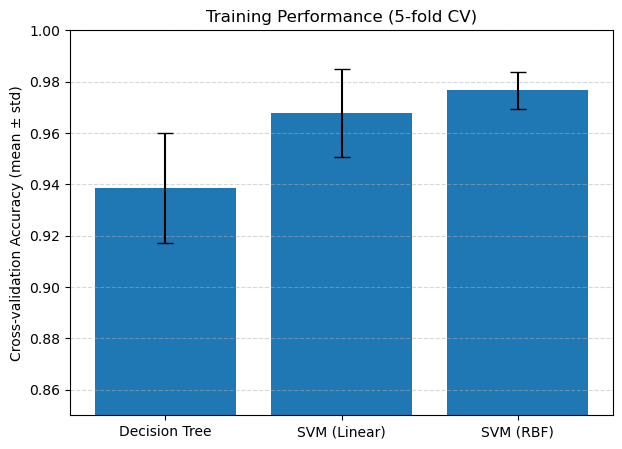

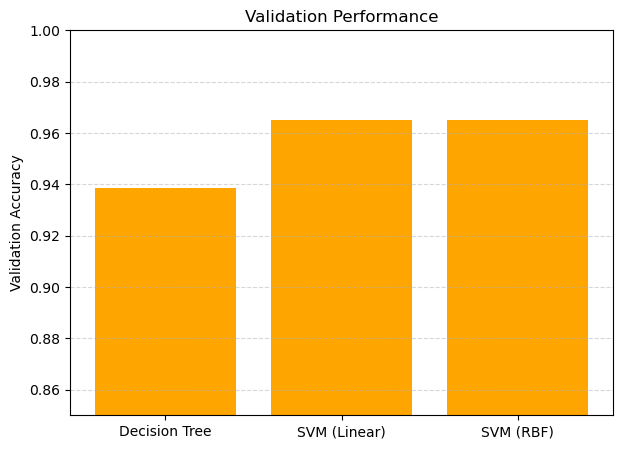

In [47]:
plt.figure(figsize=(7,5))
plt.bar(perf["Model"], perf["CV Mean"], yerr=perf["CV Std"], capsize=6)
plt.ylabel("Cross-validation Accuracy (mean ± std)")
plt.title("Training Performance (5-fold CV)")
plt.ylim(0.85, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(7,5))
plt.bar(perf["Model"], perf["Val Acc"], color='orange')
plt.ylabel("Validation Accuracy")
plt.title("Validation Performance")
plt.ylim(0.85, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Looking at these two plots, you can see that the RBF SVM overfit a small amount to the training set, whilst the linear perform about the same which means in generalizes a little better.

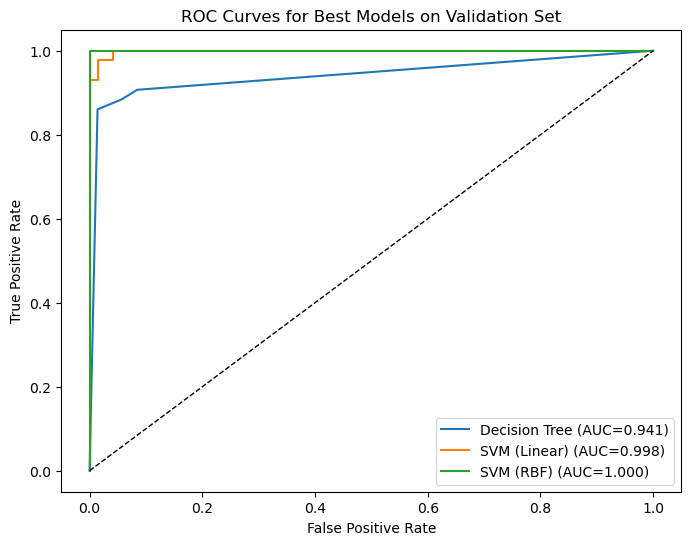

In [48]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Best Models on Validation Set")
plt.legend()
plt.show()

### Exercise 4.4 - Compare the final test set accuracy of the best Decision Tree and best SVM. Which model performs better in practice?

In [49]:
from sklearn.metrics import accuracy_score, classification_report

# Hent de beste modellene
best_dt   = dt_gs.best_estimator_
best_lin  = svm_lin_gs.best_estimator_
best_rbf  = svm_rbf_gs.best_estimator_

# Evaluer på test-settet
models = {
    "Decision Tree": best_dt,
    "SVM (Linear)": best_lin,
    "SVM (RBF)": best_rbf
}

print("\n=== Final Test Set Performance ===")
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: Test Accuracy = {acc:.4f}")



=== Final Test Set Performance ===
Decision Tree: Test Accuracy = 0.9386
SVM (Linear): Test Accuracy = 0.9561
SVM (RBF): Test Accuracy = 0.9912


{'Decision Tree': 0.9386, 'SVM (Linear)': 0.9561, 'SVM (RBF)': 0.9912}


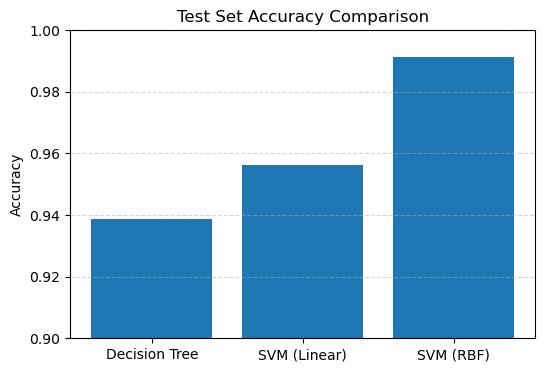

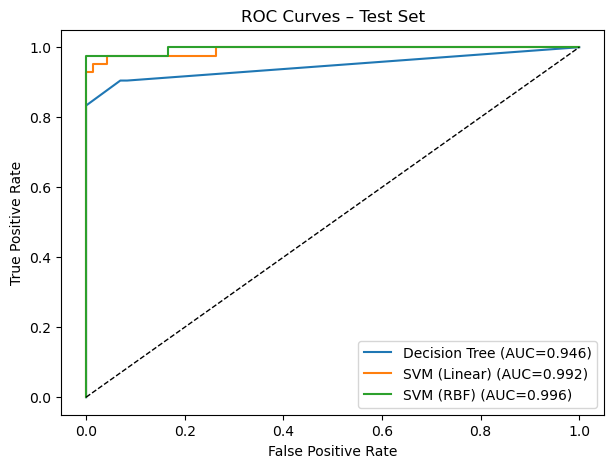

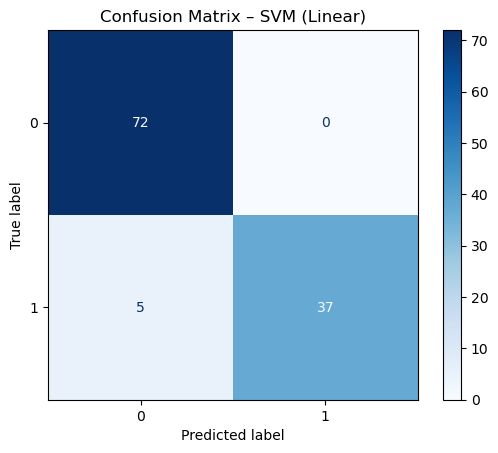

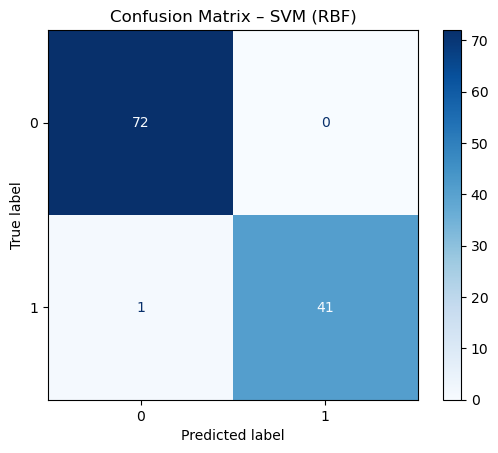

In [52]:
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# best models from your GridSearchCV runs
models = {
    "Decision Tree": dt_gs.best_estimator_,
    "SVM (Linear)":  svm_lin_gs.best_estimator_,
    "SVM (RBF)":     svm_rbf_gs.best_estimator_,
}

# compute test accuracies (no hardcoding)
test_accs = {name: accuracy_score(y_test, mdl.predict(X_test))
             for name, mdl in models.items()}

print({k: round(v, 4) for k, v in test_accs.items()})

# bar chart
plt.figure(figsize=(6,4))
plt.bar(test_accs.keys(), test_accs.values())
plt.ylabel("Accuracy")
plt.title("Test Set Accuracy Comparison")
plt.ylim(0.9, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# 2. ROC curves
plt.figure(figsize=(7,5))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Test Set")
plt.legend()
plt.show()

linear_best_model_matrix=svm_lin_gs.best_estimator_
ConfusionMatrixDisplay.from_estimator(linear_best_model_matrix, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix – SVM (Linear)")
plt.show()

# 3. Confusion matrix for best model (RBF)
best_model = svm_rbf_gs.best_estimator_
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix – SVM (RBF)")
plt.show()


Looking at the plots you can see the RBF model performing best. The confusion matrix shows only one mis-classification, however it is a bad one. In practice, this means taht the model sees a malignant case as begign, which is very dangerous for the patient receiving this diagnosis. The accuracy of the RBF model is good, other than the mis of one case.

### 4.5 - The Breast Cancer Wisconsin dataset has 30 continuous features, many of which are correlated and not linearly separable. Explain why a linear SVM might fail to capture complex patterns in this dataset. How does using an RBF  kernel help in this case? Discuss your answer in terms of the dataset’s feature space and the geometry of the decision boundary. 